  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached pyaml-24.4.0-py3-none-any.whl.metadata (11 kB)
Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl (107 kB)
Using cached pyaml-24.4.0-py3-none-any.whl (24 kB)
Target distribution:
target
0.0    789400
1.0     10600
Name: count, dtype: int64
y_train distribution:
target
1.0    8498
0.0    8462
Name: count, dtype: int64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 

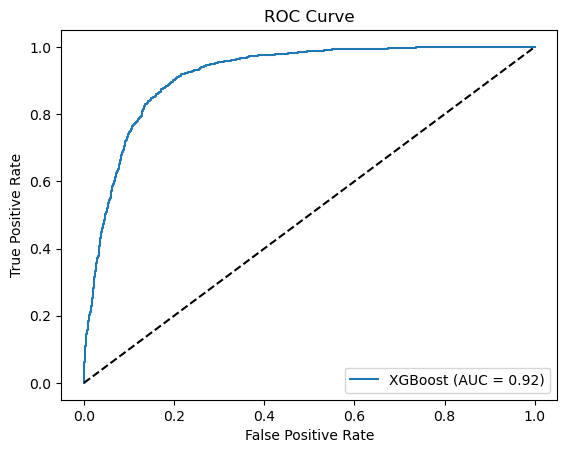

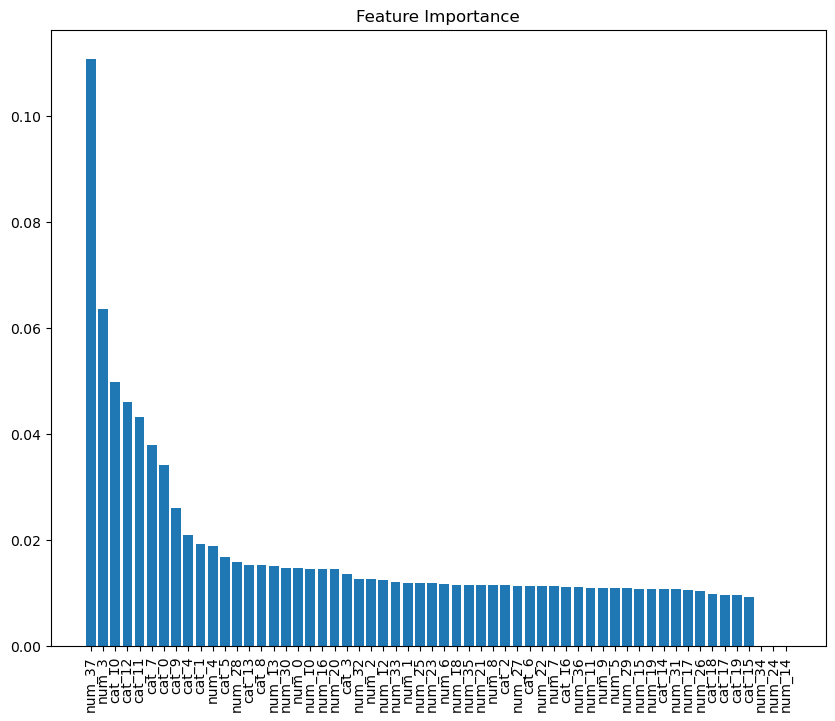

In [4]:
# Ensure bayes_opt is installed
!pip install scikit-optimize

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from xgboost import XGBClassifier
import time
import matplotlib.pyplot as plt
import numpy as np

# Record start time
start_time = time.time()

# Load dataset
data = pd.read_csv('train.csv')

# Check the distribution of the target variable
print("Target distribution:")
print(data['target'].value_counts())

# Extract positive and negative samples
positive_samples = data[data['target'] == 1]
negative_samples = data[data['target'] == 0]

# Balance the dataset by upsampling the minority class
minority_class = positive_samples
majority_class = negative_samples.sample(n=len(positive_samples), replace=True, random_state=42)
balanced_data = pd.concat([majority_class, minority_class])

# Split the dataset into features (X) and target (y)
X = balanced_data.drop(['id', 'target'], axis=1)
y = balanced_data['target']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the distribution of y_train
print("y_train distribution:")
print(y_train.value_counts())

# Define the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter distribution for Bayesian optimization
param_dist = {
    'n_estimators': (100, 300),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2, 'uniform'),
    'subsample': (0.6, 1.0, 'uniform'),
    'colsample_bytree': (0.6, 1.0, 'uniform'),
    'min_child_weight': (1, 10),
    'gamma': (0, 5, 'uniform'),
    'reg_alpha': (0, 1, 'uniform'),
    'reg_lambda': (0, 1, 'uniform')
}

# Perform Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_dist,
    n_iter=100,  # Number of iterations
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
bayes_search.fit(X_train, y_train)

# Get the top 3 best parameters
top3_results = bayes_search.cv_results_
top3_indices = np.argsort(top3_results['rank_test_score'])[:3]
top3_params = [top3_results['params'][i] for i in top3_indices]

# Evaluate each of the top 3 best parameters
best_model = None
best_auc = 0
best_params = None

for i, params in enumerate(top3_params):
    print(f"\nTop {i + 1} parameters: ", params)
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)

    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_test_pred_prob)
    print(f"Top {i + 1} AUC score:", auc_score)
    print("Classification report on test set:\n", classification_report(y_test, y_test_pred))

    if auc_score > best_auc:
        best_auc = auc_score
        best_model = model
        best_params = params

print("\nBest model parameters: ", best_params)
print("Best model AUC score: ", best_auc)

# Predict on unknown user data
unknown_users = data[data['target'] == 0].drop(['id', 'target'], axis=1)
unknown_users_scaled = scaler.transform(unknown_users)
predicted_probabilities = best_model.predict_proba(unknown_users_scaled)[:, 1]  # Get the probabilities for being a 5G user

# Set a threshold to determine which users are likely 5G users
threshold = 0.5  # This threshold can be adjusted
predicted_labels = (predicted_probabilities > threshold).astype(int)

# Save the results
results = pd.DataFrame({
    'id': data[data['target'] == 0]['id'],
    'predicted_target': predicted_labels
})
results.to_excel('predicted_results_xgboost_bayes.xlsx', index=False)

print("Prediction results saved to predicted_results_xgboost_bayes.xlsx")

# Record end time and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Code run time: {elapsed_time:.2f} seconds")

# Plot the ROC curve for the best model
y_test_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {best_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Feature importance analysis
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), X.columns[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.show()
